# Configurations

### Import

In [1]:
import os
import copy
import joblib
from IPython.display import clear_output
from tqdm import tqdm

import holidays
import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import torch
import pytorch_model_summary
import torch.nn.functional as F
from transformers import ViTModel, ViTImageProcessor, ViTConfig, BertModel, BertConfig, BertTokenizer, DistilBertModel, DistilBertTokenizer, DistilBertConfig
import timm
from torchvision import transforms
from PIL import Image
import cv2
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [2]:
# Data params
encoder_len = 30
pred_len = 7
# batch_size = 10
batch_size = 128

# Model hyperparameter
d_model = 128; #d_model = 256; #d_model = 512
nhead = 4; nhead = 1
d_ff = 512; d_ff = 256
dropout = 0.3
num_layers = 4; num_layers = 1

# Data

### Read

In [3]:
# Read transaction
df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
df_meta = df_meta[["article_id"] + [col for col in df_meta.columns if "name" in col]]

df_trans_sample = df_trans.iloc[:10000]

### Preprocess

In [4]:
def preprocess(data, meta, encoder_len, pred_len, is_train=True):
    data = data.copy()

    seq_col_li = ["price", "year", "month_sin", "month_cos", "dayofweek_sin", "dayofweek_cos", "day_sin", "day_cos"]
    # cat_col_li = ["colour_group_name", "perceived_colour_value_name", "index_name", "section_name"]
    cat_col_li = ["prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

   # Img_path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

   # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))

   # Expand dates
    data = data.set_index("t_dat").groupby(["article_id", "img_path"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")

   # Merge
    data = pd.merge(data, meta, on="article_id")

   # Temporal informations
    data["year"] = data["t_dat"].dt.year
    data["month"] = data["t_dat"].dt.month
    data["dayofweek"] = data["t_dat"].dt.dayofweek
    data["day"] = data["t_dat"].dt.day

    # Cyclic transformation
    def append_cyclic(col, cycle):
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col]/cycle)
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col]/cycle)
    
    append_cyclic("month", 12)
    append_cyclic("dayofweek", 7)
    append_cyclic("day", 365)
    data = data.drop(["month", "dayofweek", "day"], axis=1)
   
   # Aggregate to list
    data = data.groupby(["article_id", "img_path"] + cat_col_li, as_index=False)\
                        [["sales"] + seq_col_li].agg(list)

    return data.reset_index(drop=True), seq_col_li, cat_col_li

df_prep, seq_col_li, cat_col_li = preprocess(df_trans, df_meta, encoder_len, pred_len)

# Save
df_prep.to_parquet("df_prep.parquet")
joblib.dump(seq_col_li, "seq_col_li.pkl")
joblib.dump(cat_col_li, "cat_col_li.pkl")

['cat_col_li.pkl']

### Dataset

In [3]:
# Reference
df_prep = pd.read_parquet("df_prep.parquet")
# df_prep = df_prep[df_prep["index_name"] == "Ladieswear"]
df_prep = df_prep[df_prep["section_name"] == "Womens Casual"]
seq_col_li = joblib.load("seq_col_li.pkl")
seq_col_li.remove("year")
seq_col_li.remove("price")
cat_col_li = joblib.load("cat_col_li.pkl")

# Filter
df_prep["size"] = df_prep["sales"].str.len()
df_prep = df_prep[df_prep["size"] >= encoder_len + pred_len]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_col_li, cat_col_li, encoder_len, pred_len):
        self.sales_li, self.temporal_li, self.static_li, self.static_label_li, self.img_li = [], [], [], [], []
        for _, row in tqdm(data.iterrows()):
           # Sales and temporal
            sales_temporal = np.array([i.astype(float) for i in row[["sales"] + seq_col_li].values]).T
            scaler = StandardScaler()
            sales_temporal[:, 0] = scaler.fit_transform(sales_temporal[:, 0].reshape(-1,1)).reshape(-1)
            sales_temporal = torch.FloatTensor(sales_temporal).unfold(0, encoder_len+pred_len, 1).permute(0,2,1)
            sales = sales_temporal[:, :, 0].numpy()
            temporal = sales_temporal[:, :, 1:].numpy()
            
           # Static and image
            static_label_img = row[cat_col_li + ["img_path"]].values[None, ...]
            static_label_img = np.repeat(static_label_img, temporal.shape[0], 0)

            static = static_label_img[:, :len(cat_col_li)]
            img = static_label_img[:, -1]

           # Filter non-zero
            nonzero_idx1 = np.where(sales[:, :-pred_len].sum(axis=-1) > 0)[0] # At least one non-zero from sales X
            nonzero_idx2 = np.where(sales[:, -pred_len:].sum(axis=-1) > 0)[0] # At least one non-zero from sales y
            nonzero_idx = list(set(nonzero_idx1).intersection(set(nonzero_idx2))) # And condition (intersection)
            
            self.sales_li.append(sales[nonzero_idx])
            self.temporal_li.append(temporal[nonzero_idx])
            self.static_li.append(static[nonzero_idx])
            self.img_li.append(img[nonzero_idx])
        
        self.sales_li = np.concatenate(self.sales_li)
        self.temporal_li = np.concatenate(self.temporal_li)
        self.static_li = np.concatenate(self.static_li)
        self.img_li = np.concatenate(self.img_li)
        
        self.transform = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

    def __len__(self):
        return len(self.sales_li)
    
    def __getitem__(self, idx):
        # hist = np.log1p(self.sales_li[idx][:-pred_len][..., None])
        # y = np.log1p(self.sales_li[idx][-pred_len:][..., None])

        hist = self.sales_li[idx][:-pred_len][..., None]
        y = self.sales_li[idx][-pred_len:][..., None]
        
        temporal = self.temporal_li[idx]
        static = self.static_li[idx]
        
        img = Image.open(self.img_li[idx]).convert("RGB")
        img_tensor = self.transform(img, return_tensors="np", train=False)["pixel_values"].squeeze(0)

        return hist, temporal, static, img, img_tensor, y

def func(data, tokenizer):
    hist = np.array([hist for hist, temporal, static, img, img_tensor, y in data])
    temporal = np.array([temporal for hist, temporal, static, img, img_tensor, y in data])

    static = np.array([static for hist, temporal, static, img, img_tensor, y in data])
    static = tokenizer(static.flatten().tolist(), return_tensors="pt", padding=True, add_special_tokens=False)

    img_raw = [img for hist, temporal, static, img, img_tensor, y in data]
    img_tensor = np.array([img_tensor for hist, temporal, static, img, img_tensor, y in data])

    y = np.array([y for hist, temporal, static, img, img_tensor, y in data])

    return torch.FloatTensor(hist), torch.FloatTensor(temporal), static, img_raw, torch.FloatTensor(img_tensor), torch.FloatTensor(y)

# Define tools
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# tokenizer = DistilBertTokenizer(never_split=True)

# Define dataset and loader
dataset = Dataset(df_prep, seq_col_li, cat_col_li, encoder_len, pred_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: func(x, tokenizer), num_workers=8, prefetch_factor=8, drop_last=True) # num_workers=8, prefetch_factor=8
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: func(x, tokenizer))

for data in dataloader:
    hist, temporal, static, img_raw, img_tensor, y = data
    print("hist:", hist.shape)
    print("temporal:", temporal.shape)
    print("static['input_ids']:", static["input_ids"].shape)
    # print("img_raw:", img_raw.shape)
    print("img_tensor:", img_tensor.shape)
    print("_"*100)
    print("y:", y.shape)
    break


2471it [00:01, 1527.93it/s]


hist: torch.Size([128, 30, 1])
temporal: torch.Size([128, 37, 6])
static['input_ids']: torch.Size([1536, 10])
img_tensor: torch.Size([128, 3, 224, 224])
____________________________________________________________________________________________________
y: torch.Size([128, 7, 1])


### Load

# Architecture

In [4]:
def positional_embedding(max_len, d_model, dropout, x):
    position = torch.arange(max_len).reshape(-1,1).to(device)
    i = torch.arange(d_model).to(device)//2
    exp_term = 2*i/d_model
    div_term = torch.pow(10000, exp_term).reshape(1, -1)
    pos_encoded = position / div_term

    pos_encoded[:, 0::2] = torch.sin(pos_encoded[:, 0::2])
    pos_encoded[:, 1::2] = torch.cos(pos_encoded[:, 1::2])


    return torch.nn.Dropout(dropout)(x + pos_encoded[:x.shape[1], :])

def get_padding_mask(arr):
    res = torch.where(arr==0, -torch.inf, 0)
    return res

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None, size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class FeedForwardEmbedder(torch.nn.Module):
    def __init__(self, input_dim, d_model, d_ff, dropout):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_dim, d_ff)
        self.activation = torch.nn.GELU()
        self.dropout = torch.nn.Dropout(dropout)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

class CustomEncoderLayer(torch.nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation, batch_first):
        super().__init__(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, batch_first=batch_first)
    
    def forward(self, src, positional_embedding, src_mask=None, src_key_padding_mask=None, is_causal=False):
       #################################################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(src_mask),
            other_name="src_mask",
            target_type=src.dtype)

        src_mask = F._canonical_mask(
            mask=src_mask,
            mask_name="src_mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,)

        # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf
        why_not_sparsity_fast_path = ''
        if not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif self.training:
            why_not_sparsity_fast_path = "training is enabled"
        elif not self.self_attn.batch_first :
            why_not_sparsity_fast_path = "self_attn.batch_first was not True"
        elif not self.self_attn._qkv_same_embed_dim :
            why_not_sparsity_fast_path = "self_attn._qkv_same_embed_dim was not True"
        elif not self.activation_relu_or_gelu:
            why_not_sparsity_fast_path = "activation_relu_or_gelu was not True"
        elif not (self.norm1.eps == self.norm2.eps):
            why_not_sparsity_fast_path = "norm1.eps is not equal to norm2.eps"
        elif src.is_nested and (src_key_padding_mask is not None or src_mask is not None):
            why_not_sparsity_fast_path = "neither src_key_padding_mask nor src_mask are not supported with NestedTensor input"
        elif self.self_attn.num_heads % 2 == 1:
            why_not_sparsity_fast_path = "num_head is odd"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"
        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                self.self_attn.in_proj_weight,
                self.self_attn.in_proj_bias,
                self.self_attn.out_proj.weight,
                self.self_attn.out_proj.bias,
                self.norm1.weight,
                self.norm1.bias,
                self.norm2.weight,
                self.norm2.bias,
                self.linear1.weight,
                self.linear1.bias,
                self.linear2.weight,
                self.linear2.bias,
            )

            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            _supported_device_type = ["cpu", "cuda"]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif not all((x.device.type in _supported_device_type) for x in tensor_args):
                why_not_sparsity_fast_path = ("some Tensor argument's device is neither one of "
                                              f"{_supported_device_type}")
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if not why_not_sparsity_fast_path:
                merged_mask, mask_type = self.self_attn.merge_masks(src_mask, src_key_padding_mask, src)
                return torch._transformer_encoder_layer_fwd(
                    src,
                    self.self_attn.embed_dim,
                    self.self_attn.num_heads,
                    self.self_attn.in_proj_weight,
                    self.self_attn.in_proj_bias,
                    self.self_attn.out_proj.weight,
                    self.self_attn.out_proj.bias,
                    self.activation_relu_or_gelu == 2,
                    self.norm_first,
                    self.norm1.eps,
                    self.norm1.weight,
                    self.norm1.bias,
                    self.norm2.weight,
                    self.norm2.bias,
                    self.linear1.weight,
                    self.linear1.bias,
                    self.linear2.weight,
                    self.linear2.bias,
                    merged_mask,
                    mask_type,
                )
       #################################################################################################################################################
        query = src + positional_embedding
        key = src + positional_embedding
        value = src
        if self.norm_first:
            print("norm_first not suppoted")
            raise
        else:
            x = self.norm1(src + self._sa_block(query, key, value, src_mask, src_key_padding_mask, is_causal=is_causal))
            x = self.norm2(x + self._ff_block(x))

        return x
    
    def _sa_block(self, query, key, value, attn_mask, key_padding_mask, is_causal=False):
            x = self.self_attn(query, key, value,
                            attn_mask=attn_mask,
                            key_padding_mask=key_padding_mask,
                            need_weights=False, is_causal=is_causal)[0]
            
            return self.dropout1(x)

class CustomEncoder(torch.nn.TransformerEncoder):
    def __init__(self, encoder_layer, num_layers):
        super().__init__(encoder_layer=encoder_layer, num_layers=num_layers)
    
    def forward(self, src, positional_embedding, mask=None, src_key_padding_mask=None, is_causal=None):
       ##########################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda"]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ##########################################################################
        for mod in self.layers:
            output = mod(output, positional_embedding, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output

class DecoderLayer(torch.nn.TransformerDecoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation, batch_first):
        super().__init__(d_model, nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, batch_first=batch_first)
        self.multihead_attn1 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.multihead_attn2 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.multihead_attn3 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.norm4 = torch.nn.LayerNorm(d_model)
        self.norm5 = torch.nn.LayerNorm(d_model)
    
    def forward(self, tgt, memory1, memory2, memory3, 
                        decoder_positional_embedding, hist_positional_embedding, img_positional_embedding, static_positional_embedding,
                        hist_key_padding_mask, static_key_padding_mask, 
                        tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=False, memory_is_causal=False):
        if self.norm_first:
            print("norm_first not supported")
            raise
        else:
            # Self attention
            query = tgt + decoder_positional_embedding
            key = tgt + decoder_positional_embedding
            value = tgt
            self_attn = self.norm1(tgt + self._sa_block(query, key, value, tgt_mask, tgt_key_padding_mask, tgt_is_causal))

            # Hist cross attnetion
            attn_weight1 = None
            query = self_attn + decoder_positional_embedding
            key = memory1 + hist_positional_embedding
            value = memory1
            mha_output, attn_weight1 = self._mha_block(self.multihead_attn1, query, key, value, memory_mask, hist_key_padding_mask, memory_is_causal)
            # x = self.norm2(x + mha_output)
            hist = self.norm2(tgt + mha_output)

            # Static cross attention
            attn_weight2 = None
            query = hist + decoder_positional_embedding
            key = memory2 + static_positional_embedding
            value = memory2
            mha_output, attn_weight2 = self._mha_block(self.multihead_attn2, query, key, value, memory_mask, static_key_padding_mask, memory_is_causal)
            static = self.norm3(hist + mha_output)

            # # Image cross attention
            attn_weight3 = None
            query = static + decoder_positional_embedding
            key = memory3 + img_positional_embedding
            value = memory3
            mha_output, attn_weight3 = self._mha_block(self.multihead_attn3, query, key, value, memory_mask, memory_key_padding_mask, memory_is_causal)
            img = self.norm4(static + mha_output)

            x = img
            # Feed forward
            x = self.norm5(x + self._ff_block(x))

        return x, attn_weight1, attn_weight2, attn_weight3

    # self-attention block
    def _sa_block(self, query, key, value, attn_mask, key_padding_mask, is_causal=False):
        x = self.self_attn(query, key, value,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           is_causal=is_causal,
                           need_weights=False)[0]
        return self.dropout1(x)

    # multihead attention block
    def _mha_block(self, block, query, key, value, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = block(query, key, value,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                is_causal=is_causal,
                                need_weights=True, average_attn_weights=False)
        return self.dropout2(x), attn_weight

class Decoder(torch.nn.TransformerDecoder):
    def __init__(self, decoder_layer, num_layers):
        super().__init__(decoder_layer, num_layers)
    
    def forward(self, tgt, memory1, memory2, memory3, 
                    decoder_positional_embedding, hist_positional_embedding, img_positional_embedding, static_positional_embedding,
                    hist_key_padding_mask, static_key_padding_mask,
                    tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=None, memory_is_causal=False):
        output = tgt
        seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
        tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

        for mod in self.layers:
            output, attn_weight1, attn_weight2, attn_weight3 = mod(tgt, memory1, memory2, memory3, decoder_positional_embedding, hist_positional_embedding, img_positional_embedding, static_positional_embedding,
                        tgt_mask=tgt_mask,
                        memory_mask=memory_mask,
                        tgt_key_padding_mask=tgt_key_padding_mask,
                        hist_key_padding_mask=hist_key_padding_mask, 
                        static_key_padding_mask=static_key_padding_mask,
                        memory_key_padding_mask=memory_key_padding_mask,
                        tgt_is_causal=tgt_is_causal,
                        memory_is_causal=memory_is_causal)

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight1, attn_weight2, attn_weight3

class Transformer(torch.nn.Module):
    def __init__(self, seq_col_li, cat_col_li, encoder_len, pred_len, 
                d_model, nhead, num_layers, d_ff, dropout):
        super().__init__()
       
       # Positional embedding and mask
        self.temporal_embedder = torch.nn.GRU(len(seq_col_li), d_model, num_layers=num_layers, batch_first=True)

       # Hist enncoder
        self.hist_embedder = torch.nn.GRU(1, d_model, num_layers=num_layers, batch_first=True)
        hist_encoder_layer = CustomEncoderLayer(d_model, nhead, dim_feedforward=d_ff, dropout=dropout, activation="gelu", batch_first=True)
        self.hist_encoder = CustomEncoder(hist_encoder_layer, num_layers=num_layers)

       # Static encoder
        configuration = BertConfig(hidden_size=d_model, num_hidden_layers=num_layers, num_attention_heads=nhead, intermediate_size=d_ff, hidden_dropout_prob=dropout, attention_probs_dropout_prob=dropout)
        # self.static_embedder = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
        self.static_embedder = BertModel(configuration).to(device)

       # Image encoder
        configuration = ViTConfig(hidden_size=d_model, num_hidden_layers=num_layers, num_attention_heads=nhead, intermediate_size=d_ff, patch_size=14, hidden_dropout_prob=dropout, attention_probs_dropout_prob=dropout)
        self.img_model = ViTModel(configuration).to(device)

       # Decoder
        decoder_layer = DecoderLayer(d_model, nhead, dim_feedforward=d_ff, dropout=dropout, activation="gelu", batch_first=True)
        self.decoder = Decoder(decoder_layer, num_layers)

       # Final
        self.linear_binary = torch.nn.Linear(d_model, 1)
        self.linear_numerical = torch.nn.Linear(d_model, 1)

    def forward(self, hist, temporal, static_input_ids, static_attention_mask, img, verbose=False):
       # Positional embedding
        temporal_embedding, _ = self.temporal_embedder(temporal)
        hist_positional_embedding = temporal_embedding[:, :encoder_len, :]
        decoder_positional_embedding = temporal_embedding[:, -pred_len:, :]
    
       # Encoder
        # Hist encoder
        hist_padding_mask = get_padding_mask(hist).squeeze(-1)
        hist_embedding, _ = self.hist_embedder(hist)
        hist_enc_output = self.hist_encoder(hist_embedding, hist_positional_embedding)

        # Static encoder
        static = {"input_ids": static_input_ids, "attention_mask":static_attention_mask}
        static_key_padding_mask = torch.where(static["attention_mask"]==1, 0, -torch.inf).reshape(hist.shape[0], -1)
        static_enc_output = self.static_embedder(**static)["last_hidden_state"].reshape(hist.shape[0], len(cat_col_li), -1, d_model).reshape(hist.shape[0], -1, d_model)
        static_positional_embedding = self.static_embedder.embeddings.position_embeddings.weight[:static_enc_output.shape[1]]

        # Image encoder
        img = {"pixel_values":img}
        img_enc_output = self.img_model(**img)["last_hidden_state"]
        img_positional_embedding = self.img_model.embeddings.position_embeddings
        
    
       # Decoder
        decoder_output, attn_weight1, attn_weight2, attn_weight3 = self.decoder(tgt=decoder_positional_embedding,
                                                                                memory1=hist_enc_output, memory2=static_enc_output, memory3=img_enc_output,
                                                                                decoder_positional_embedding=decoder_positional_embedding, hist_positional_embedding=hist_positional_embedding, img_positional_embedding=img_positional_embedding, static_positional_embedding=static_positional_embedding,
                                                                                hist_key_padding_mask=None, static_key_padding_mask=static_key_padding_mask)

       # Final
        output_binary = self.linear_binary(decoder_output)
        output_numerical = self.linear_numerical(decoder_output)

        return output_binary, output_numerical, attn_weight1, attn_weight2, attn_weight3, temporal_embedding

model = Transformer(seq_col_li, cat_col_li, encoder_len, pred_len, 
                    d_model, nhead, num_layers, d_ff, dropout)
model.to(device)

pytorch_model_summary.summary(model, 
                hist[0].unsqueeze(0).to(device),
                temporal[0].unsqueeze(0).to(device),
                static["input_ids"][0:len(cat_col_li)].to(device),
                static["attention_mask"][0:len(cat_col_li)].to(device),
                img_tensor[0].unsqueeze(0).to(device),
                show_parent_layers=True, # show_hierarchical=True,
                print_summary=True
                            )

# model = torch.nn.DataParallel(model)

----------------------------------------------------------------------------------------------------------------------------------
   Parent Layers       Layer (type)                                                   Output Shape         Param #     Tr. Param #
     Transformer              GRU-1                                      [1, 37, 128], [1, 1, 128]          52,224          52,224
     Transformer              GRU-2                                      [1, 30, 128], [1, 1, 128]          50,304          50,304
     Transformer    CustomEncoder-3                                                   [1, 30, 128]         132,480         132,480
     Transformer        BertModel-4                                                  [12, 10, 128]       4,121,856       4,121,856
     Transformer         ViTModel-5                                                  [1, 257, 128]         257,664         257,664
     Transformer          Decoder-6     [1, 7, 128], [1, 1, 7, 30], [1, 1, 7, 120],

'----------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)                                                   Output Shape         Param #     Tr. Param #\n==================================================================================================================================\n     Transformer              GRU-1                                      [1, 37, 128], [1, 1, 128]          52,224          52,224\n     Transformer              GRU-2                                      [1, 30, 128], [1, 1, 128]          50,304          50,304\n     Transformer    CustomEncoder-3                                                   [1, 30, 128]         132,480         132,480\n     Transformer        BertModel-4                                                  [12, 10, 128]       4,121,856       4,121,856\n     Transformer         ViTModel-5                                        

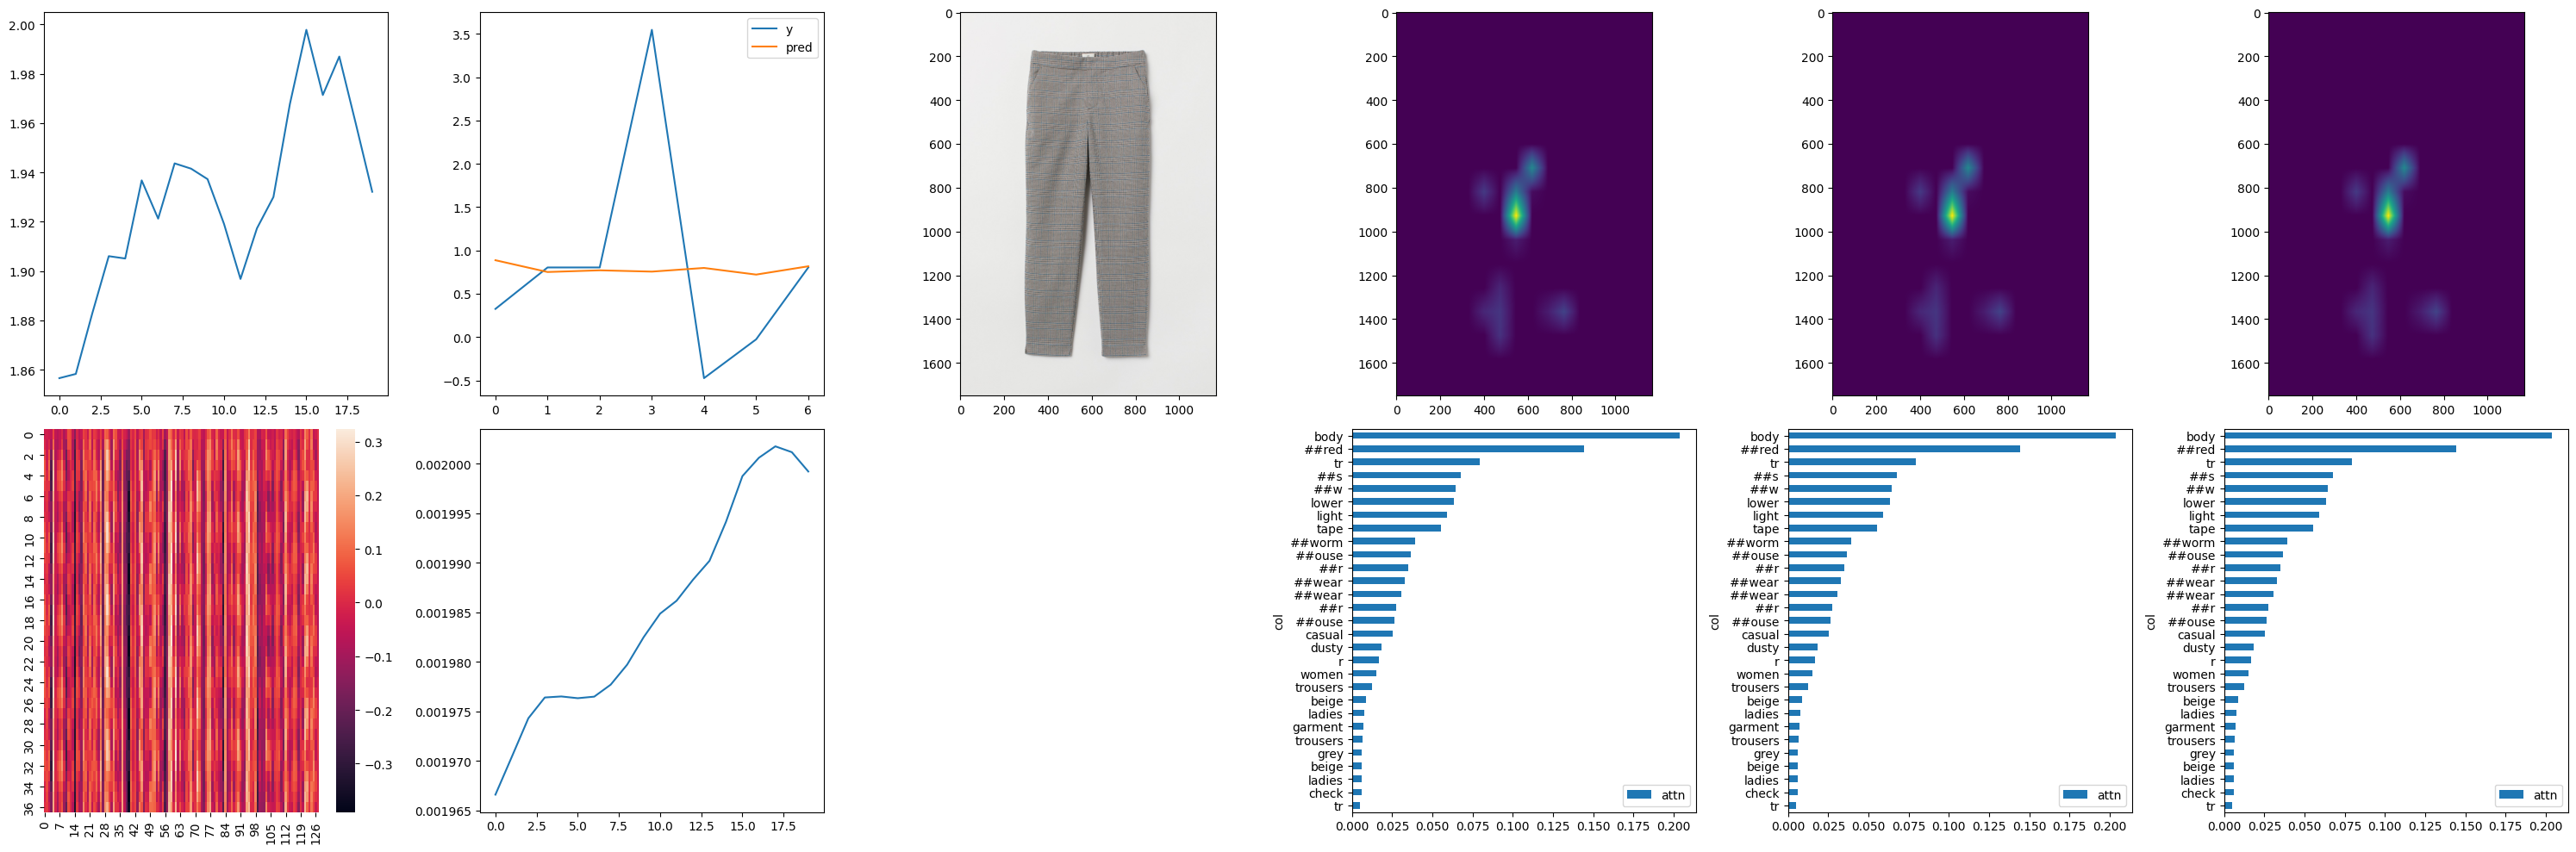

epoch0 - loss: 1.93278 - lr: 0.0008120378896731916:  10%|▉         | 103/1054 [04:12<31:40,  2.00s/it]

In [5]:
patience = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", eps=1e-15, patience=patience)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.998)
binary_loss_fn_ = torch.nn.BCEWithLogitsLoss()
mse_loss_fn_ = torch.nn.MSELoss()

def binary_loss_fn(pred, y):
    y = torch.where(y==0, 0, 1).type(torch.FloatTensor).to(device)
    loss = binary_loss_fn_(pred, y)
    return loss

def mse_loss_fn(pred, y):
    mask = torch.where(y==0, 0, 1).type(torch.FloatTensor).to(device)
    loss = mse_loss_fn_(pred, y.to(device))
    masked_loss = loss * mask
    average_loss = masked_loss.sum() / mask.sum()
    return loss

def plot_sample(y, pred, loss_li, img_raw, attn_weight1, attn_weight2, attn_weight3, temporal_embedding, gradient_li, static):
    clear_output(wait=True)
    y_sample, pred_sample = y[-1], pred[-1].detach().cpu()

    plt.figure(figsize=(30,10))
    nrows = 2
    ncols = 6

   # Plot loss
    plt.subplot(nrows, ncols, 1)
    plt.plot(loss_li[-patience:], label="Loss")
   
   # Plot sample prediction
    plt.subplot(nrows, ncols, 2)
    plt.plot(y_sample, label="y")
    plt.plot(pred_sample, label="pred")
    plt.legend()

    idx = -1
   # Plot img attention mask
    plt.subplot(nrows, ncols, 3)
    plt.imshow(img_raw[idx])

    plt.subplot(nrows, ncols, 4)
    mask = torch.min(attn_weight3, dim=1).values
    mask = torch.mean(mask, dim=1)
    mask = mask[idx, 1:].reshape(16,16).cpu().detach().numpy() # 28,28 or 14,14
    mask = cv2.resize(mask / mask.max(), img_raw[idx].size)[..., np.newaxis]
    plt.imshow(mask)

    plt.subplot(nrows, ncols, 5)
    mask = torch.mean(attn_weight3, dim=1)
    mask = torch.mean(mask, dim=1)
    mask = mask[idx, 1:].reshape(16,16).cpu().detach().numpy() # 28,28 or 14,14
    mask = cv2.resize(mask / mask.max(), img_raw[idx].size)[..., np.newaxis]
    plt.imshow(mask)

    plt.subplot(nrows, ncols, 6)
    mask = torch.max(attn_weight3, dim=1).values
    mask = torch.mean(mask, dim=1)
    mask = mask[idx, 1:].reshape(16,16).cpu().detach().numpy() # 28,28 or 14,14
    mask = cv2.resize(mask / mask.max(), img_raw[idx].size)[..., np.newaxis]
    plt.imshow(mask)

  # Plot positional encoding heatmap
    plt.subplot(nrows, ncols, 7)
    sns.heatmap(temporal_embedding[idx].detach().cpu())

  # Plot gradient
    plt.subplot(nrows, ncols, 8)
    plt.plot(gradient_li)

  # Plot static
    static = static.reshape(batch_size, -1)[idx]
    token = tokenizer.convert_ids_to_tokens(static)
    
    mask_min = torch.mean(torch.min(attn_weight2, dim=1).values[idx], dim=0).detach().cpu()
    mask_max = torch.mean(torch.max(attn_weight2, dim=1).values[idx], dim=0).detach().cpu()
    mask_mean = torch.mean(torch.mean(attn_weight2, dim=1)[idx], dim=0).detach().cpu()

    plt.subplot(nrows, ncols, 10)
    df = pd.DataFrame()
    df["col"] = token
    df["attn"] = mask_min
    df = df[df["col"] != "[PAD]"].sort_values("attn")
    df.plot.barh(x="col", y="attn", ax=plt.gca())

    plt.subplot(nrows, ncols, 11)
    df = pd.DataFrame()
    df["col"] = token
    df["attn"] = mask_mean
    df = df[df["col"] != "[PAD]"].sort_values("attn")
    df.plot.barh(x="col", y="attn", ax=plt.gca())

    plt.subplot(nrows, ncols, 12)
    df = pd.DataFrame()
    df["col"] = token
    df["attn"] = mask_max
    df = df[df["col"] != "[PAD]"].sort_values("attn")
    df.plot.barh(x="col", y="attn", ax=plt.gca())
    
    plt.tight_layout()
    plt.show()
  
def train(e):
    model.train()
    loss_li, loss_mean_li = [], []
    gradient_li = []
    pbar = tqdm(dataloader)
    patience_idx = 0

    for n, data in enumerate(pbar):
        hist, temporal, static, img_raw, img_tensor, y = data
       
       # Train
        optimizer.zero_grad()
        output_binary, output_numerical, attn_weight1, attn_weight2, attn_weight3, temporal_embedding = model(
                hist.to(device),
                temporal.to(device),
                static["input_ids"].to(device),
                static["attention_mask"].to(device),
                img_tensor.to(device),
        )
        mse_loss = mse_loss_fn(output_numerical, y)
        binary_loss = binary_loss_fn(output_binary, y)
        loss = mse_loss + binary_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        
       # Report
        gradient_li.append(list(model.named_parameters())[-2][1].mean().detach().cpu())
        loss_li.append(loss.item())
        loss_mean_li.append(np.mean(loss_li[-patience:]))
        pbar.set_description(f'epoch{e} - loss: {np.round(np.mean(loss_mean_li[-patience:]), 5)} - lr: {optimizer.param_groups[0]["lr"]}')
        plot_sample(torch.expm1(y), output_numerical, loss_mean_li, img_raw, attn_weight1, attn_weight2, attn_weight3, temporal_embedding, gradient_li[-patience:], static["input_ids"])

temp = None
epoch = 5
for e in range(epoch):
    train(e)